In [0]:
path = 'drive/My Drive/Colab Notebooks/fiztex2/adversarial/'

In [0]:
# import zipfile
# with zipfile.ZipFile(path + 'imgs.zip', 'r') as zip_ref:
#     zip_ref.extractall(path)

In [0]:
!pip install pytorch-msssim
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os
from PIL import Image
from pytorch_msssim import ssim, ms_ssim
from collections import defaultdict

from torch.autograd import Variable

In [0]:
'''ResNet in PyTorch.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''

"""
pre-trained weights:
https://drive.google.com/file/d/1K5zBBxYRzFDqPQqGQ15Lo4vjrexwVtM1/view
"""

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=512):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.fc_bn = nn.BatchNorm1d(512)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 7)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.fc_bn(out)
        return out

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

In [0]:
net = ResNet50()
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

In [0]:
# net.load_state_dict(torch.load(path + 'best_model_chkpt-resnet50.t7'), strict=False)

checkpoint = torch.load(path + "./best_model_chkpt-resnet50.t7") 
net.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [0]:
df = pd.read_csv(path + './pairs_list.csv')

In [0]:
df

,source_imgs,target_imgs
0,60f5fb295648e54bd1dc0c859c8fff620ee2eb40.jpg|b...,48f9c10f6e20153d752bbb7248016df80a16f4c3.jpg|2...
1,3e15d19b62ba5c991e8a0d9f85ddb3d8adde9a31.jpg|9...,d53757cc366571251a74d4df211b05b67a279eb2.jpg|d...
2,2cf2e394b1a4fa1d4f71a11deb5eaccfd757d668.jpg|2...,8f9faa1124481d2749ca5ec90c8762fb69a244b7.jpg|b...
3,dcf724dec8125b19bbdc5ab328f3affcdd124a3a.jpg|b...,b57e0e26f0198f3c99626a704849c88506933959.jpg|2...
4,589b3c020dbebb39d52c874dee3c4b84c4ea031a.jpg|5...,76931fc56b77730739eb46ee00da61bd4ef30b83.jpg|d...
...,...,...
995,834eab03e73504116afef6c1264842c5d7f84ad4.jpg|1...,b5265f85023c8aa7f7035b7a32824bccd498459e.jpg|9...
996,f8769ec362fe42f7e3a5e3d1ffb7f53cd49a5507.jpg|2...,662a61c2dbf65dd72716665757d52363d03156ca.jpg|e...
997,d59407fc2a67e2374a0ffaedcf6cac4579e780f2.jpg|6...,8fde1f59bbc452ce51c4c168d2dbfab88b609b18.jpg|8...
998,49c863da3436ddd24877b5b6d413a8cf8799ba21.jpg|8...,6afcb233bef2a9af57afc77fd6526625ddfd9688.jpg|d...


In [0]:
# random row 
r = np.random.randint(len(df))
r

531

In [0]:
df.loc[r].source_imgs.split('|')

['e7c2775f90da74acf3de9fb8516c161f8f24c7c7.jpg',
 '56f0aebbe6e1f3325d954487dcea4e32b1001217.jpg',
 'd503ca7151aa01c1df223edcfb3a5e92fce42db9.jpg',
 '028d152f20eab5f82f1747fd3749f76687981b22.jpg',
 '4986f94adeceb7010c8976ab6944dde06bd7e66d.jpg']

In [0]:
df.loc[r].target_imgs.split('|')

['0caa8aa408d05450f23e644508ab8612cc093f17.jpg',
 'b36c90b0abcd1713700e4bd9cdbb14ddff160643.jpg',
 '0fa951bf5b6c739e797b75048e2bdba544998f31.jpg',
 '5e08ff6e11dd4266c39f2dbd85033e681c6f9edd.jpg',
 '80890ab58101ecf584449ab4ef2025240f46123d.jpg']

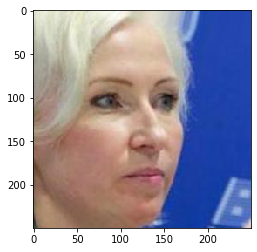

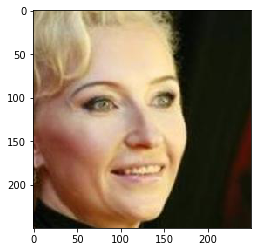

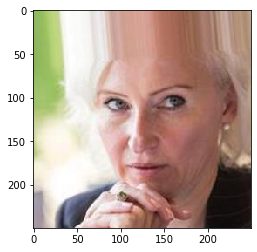

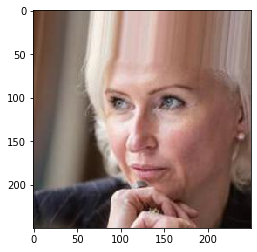

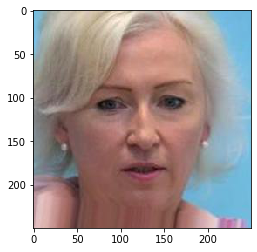

In [0]:
for f in df.loc[r].source_imgs.split('|'):
  im = plt.imread(path + 'imgs/' + f)
  plt.imshow(im)
  plt.show()

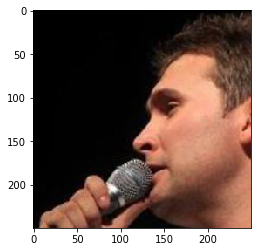

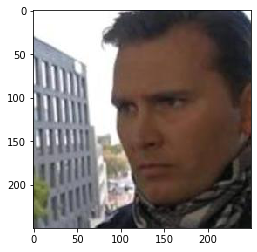

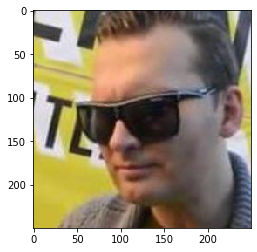

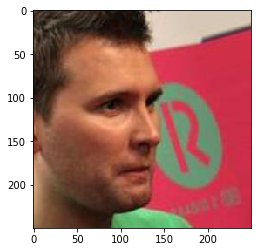

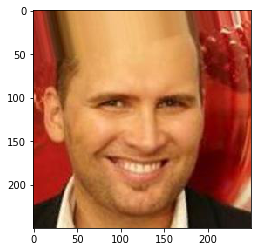

In [0]:
for f in df.loc[r].target_imgs.split('|'):
  im = plt.imread(path + 'imgs/' + f)
  plt.imshow(im)
  plt.show()

In [0]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
trans = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.Resize(112),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD),
                ])

def get_source_and_target_one_sample(r):
  source_batch = []
  target_batch = []
  for s, t in zip(df.loc[r].source_imgs.split('|'), df.loc[r].target_imgs.split('|')):
    s_im = trans(Image.open(path + 'imgs/' + s))
    t_im = trans(Image.open(path + 'imgs/' + t))

    source_batch.append(s_im)
    target_batch.append(t_im)

  return torch.stack(source_batch, dim=0), torch.stack(target_batch, dim=0)

In [0]:
r = np.random.randint(len(df))
source_im, target_im = get_source_and_target_one_sample(r)

In [0]:
source_im.shape, target_im.shape

(torch.Size([5, 3, 112, 112]), torch.Size([5, 3, 112, 112]))

In [0]:
x = net(source_im)
y = net(target_im)

x.shape, y.shape

(torch.Size([5, 512]), torch.Size([5, 512]))

In [0]:
for i in range(5):
  print(torch.nn.functional.mse_loss(x[0], x[i], reduction='mean'))

tensor(0., grad_fn=<MeanBackward0>)
tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)


In [0]:
for i in range(5):
  print(torch.nn.functional.mse_loss(x[0], y[i], reduction='mean'))

tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)


In [0]:
print(torch.randperm(5))
print(F.mse_loss(x, x[torch.randperm(5)]))
print(F.mse_loss(x, y))

tensor([2, 1, 3, 4, 0])
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)


In [0]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = -1*data_grad.sign()
    # sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [0]:
net = net.cuda()

In [0]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [0]:
len(df)

1000

In [0]:
os.mkdir(path + '/attacked_/') # directory to save attacked images 

FileExistsError: ignored

In [0]:
def attack(model, initial_eps=0.005, epsilon_factor=1.1, early_stop=100, ssim_threshold=0.95, verbose=False):
  '''
  Attack several images with slightly modified Fast Gradient Sign Attack

  :param ResNet50 model: The ResNet50 object
  :param float initial_eps: Initial epsilon value to use
  :param float epsilon_factor: Factor to multiply with epsilon after an unsuccessfull attack (should be > 1) 
  :param unsigned int early_stop: Early stop the attack when sufficient images were attacked
  :param float ssim_threshold: save only images with >= ssim_threshold
  :param boolean verbos: Whether or not print verbose information during the attacks.
  '''
  
  attacked_ims_counter = 0
  attacked_images = defaultdict(list)

  for r in range(len(df)):
    initial_loss = None
    rand_perm = torch.randperm(5)
    initial_eps_ = initial_eps
    loss = 0.5 # something more than 0.002 to enter the loop
  

    source_im, target_im = get_source_and_target_one_sample(r)
    source_im, target_im = Variable(source_im.cuda(), requires_grad=True), Variable(target_im.cuda(), requires_grad=True)
    
    x = net(source_im)
    y = net(target_im)
    
    loss_from_source = F.mse_loss(x, x[rand_perm]).item()
    loss_from_target = F.mse_loss(x, y).item()
    
    print('Processing images number ', r)
    print('Initial loss_from_source', round(loss_from_source, 4))
    print('Initial loss_from_target', round(loss_from_target, 4))
    print('Number of currently attacked images', attacked_ims_counter)
    print('-----'*40)

    net.zero_grad()
    while loss_from_source < loss_from_target and initial_eps_ < 0.5: # If initial_eps becomes > 0.5, we couldn't attack that picture 
      attacked_ims = []
      # net.zero_grad()

      loss = F.mse_loss(x, y)
      loss.backward(retain_graph=True)
      data_grad = source_im.grad.data
      for i in range(source_im.shape[0]):
        # print('initial_eps', initial_eps)
        attacked = fgsm_attack(invTrans(source_im[i]), initial_eps_, data_grad[i])
        attacked_ims.append(attacked)

      attacked_ims = torch.stack(attacked_ims, dim=0)
      x_pert = net(attacked_ims)

      # loss_pert = F.mse_loss(x_pert, y)
      loss_from_source = F.mse_loss(x_pert, x[rand_perm]).item()
      loss_from_target = F.mse_loss(x_pert, y).item()
      initial_eps_ *= epsilon_factor

    if initial_eps_ > 0.5:
      if verbose:
        print("####"*40)
        print('We couldn\'t attack the image with the number {}, epsilon became big'.format(r))
        print('Last loss_from_source', round(loss_from_source, 4), 'r ', r, 'epsilon', round(initial_eps_, 4))
        print('Last loss_from_target', round(loss_from_target, 4), 'r ', r, 'epsilon', round(initial_eps_, 4))
        print("####"*40)
    else:
      ssim_val = ssim(attacked_ims, source_im, data_range=255, size_average=False)
      for i in [i for i, x in enumerate(ssim_val) if x >= ssim_threshold]: # if x < 0.95 - we couldn't attack
        attacked_im = (attacked_ims[i].cpu().detach().numpy().transpose(1,2,0) * 255).astype(np.uint8)
        im = Image.fromarray(attacked_im)
        im.save(path + '/attacked_/' + df.loc[r].source_imgs.split('|')[i])

        attacked_ims_counter += 1
        attacked_images[r].append(df.loc[r].source_imgs.split('|')[i])
        if attacked_ims_counter == early_stop:
          print('Finished with early stopping')
          print('Total Number of Attacked Images ', attacked_ims_counter)
          return attacked_images
        if verbose:
          print("Image with number {} is attacked, and the perturbed image is saved under the path {}".format(r, path + '/attacked_/' + df.loc[r].source_imgs.split('|')[i]))
          print('Ssim_val ', ssim_val[i].item())
          print('Last loss_from_source', round(loss_from_source, 4), 'r ', r, 'epsilon', round(initial_eps_, 4))
          print('Last loss_from_target', round(loss_from_target, 4), 'r ', r, 'epsilon', round(initial_eps_, 4))

  print('Total Number of Attacked Images ', attacked_ims_counter)
  return attacked_images

attacked_images = attack(net, early_stop=10, verbose=True)

Processing images number  0
Initial loss_from_source 0.0012
Initial loss_from_target 0.003
Number of currently attacked images 0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Image with number 0 is attacked, and the perturbed image is saved under the path drive/My Drive/Colab Notebooks/fiztex2/adversarial//attacked_/60f5fb295648e54bd1dc0c859c8fff620ee2eb40.jpg
Ssim_val  0.9638727903366089
Last loss_from_source 0.0019 r  0 epsilon 0.019
Last loss_from_target 0.0018 r  0 epsilon 0.019
Image with number 0 is attacked, and the perturbed image is saved under the path drive/My Drive/Colab Notebooks/fiztex2/adversarial//attacked_/bc01280fd767ff125d851f2ccc887dce4afa834d.jpg
Ssim_val  0.9699234962463379
Last loss_from_source 0.0019 r  0 epsilon 0.019
Last loss_from_target 0.0018 r  0 epsilon 0.019
Processing images number  1
Initial loss_fro

In [0]:
attacked_images

defaultdict(list,
            {0: ['60f5fb295648e54bd1dc0c859c8fff620ee2eb40.jpg',
              'bc01280fd767ff125d851f2ccc887dce4afa834d.jpg'],
             2: ['a0e8e796e25399b481b3406793debadf80cf741a.jpg'],
             3: ['e0fe6340c28456fbab17ea4d4ffd287d18fe47d0.jpg',
              'c5816a41612cb4a962446056ac665faa4c3a2e02.jpg'],
             13: ['6725a684cc998ad8b77b741f002fc49aa7c62746.jpg'],
             14: ['d52fa9fe229591df1a30b1a0aabe033d4e948511.jpg'],
             20: ['c47e3c423f8e2aae0c27f8dd05ae97790233b789.jpg'],
             21: ['b98d8b7c2ae543f12f5ad561ad42db93df92f5d3.jpg',
              'a71768984e823c935bf378daee6cddc5ea6a9185.jpg']})

In [0]:
import random

rand_idx = random.choice(list(attacked_images.keys()))
rand_image = random.choice(attacked_images[rand_idx])
rand_idx, rand_image

(13, '6725a684cc998ad8b77b741f002fc49aa7c62746.jpg')

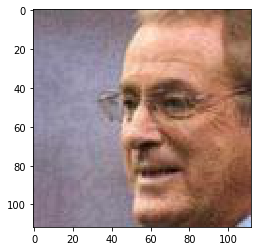

In [0]:
attacked_image = Image.open(path +'./attacked_/' + rand_image)

plt.imshow(attacked_image)
plt.show()

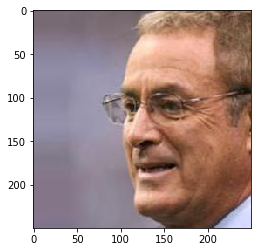

In [0]:
original_image = Image.open(path +'./imgs/' + rand_image)

plt.imshow(original_image)
plt.show()

In [0]:
df.loc[rand_idx].target_imgs.split('|')

['68d32c086a51c7acd4dbe94981dfadbdf20f7432.jpg',
 '1f1db41d7b4844d6d0c32ab5f5618e5375bd16a7.jpg',
 '457705e53f87ec285bf8a74be65f10cdda603ea4.jpg',
 '65e30aa82dbe7637d990ea4b181619d072755445.jpg',
 '7a6723c2d6f99a976d724f8251ef244d28c997d6.jpg']

In [0]:
target_ims = []

for t in df.loc[rand_idx].target_imgs.split('|'):
    t_im = trans(Image.open(path + 'imgs/' + t))

    target_ims.append(t_im)

target_ims = torch.stack(target_ims, dim=0)
target_ims.shape

torch.Size([5, 3, 112, 112])

In [0]:
original_ims = []

for s in df.loc[rand_idx].source_imgs.split('|'):
    s_im = trans(Image.open(path + 'imgs/' + s))

    original_ims.append(s_im)

original_ims = torch.stack(original_ims, dim=0)
original_ims.shape

torch.Size([5, 3, 112, 112])

In [0]:
attacked_image = trans(attacked_image)
original_image = trans(original_image)

In [0]:
attacked_image.shape, original_image.shape

(torch.Size([3, 112, 112]), torch.Size([3, 112, 112]))

In [0]:
net = ResNet50()
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

In [0]:
losses = []
for original_im in original_ims:
  loss = F.mse_loss(net(original_image.unsqueeze(0)), net(original_im.unsqueeze(0))).item()
  losses.append(loss)
  print('MSE score between original image and source(original) images:', loss)
print('Mean Loss:', np.array(losses).mean())

MSE score between original image and source images: 7.513635864597745e-06
MSE score between original image and source images: 6.95102153258631e-06
MSE score between original image and source images: 1.6626789147267118e-05
MSE score between original image and source images: 0.0
MSE score between original image and source images: 1.4270395922721946e-06
Mean Loss: 6.503697227344673e-06


In [0]:
losses = []
for original_im in original_ims:
  loss = F.mse_loss(net(attacked_image.unsqueeze(0)), net(original_im.unsqueeze(0))).item()
  losses.append(loss)
  print('MSE score between attacked image and source images:', loss)
print('Mean Loss:', np.array(losses).mean())

MSE score between attacked image and source images: 1.4479934179689735e-05
MSE score between attacked image and source images: 2.5029581593116745e-05
MSE score between attacked image and source images: 1.1051899491576478e-05
MSE score between attacked image and source images: 3.8161528209457174e-05
MSE score between attacked image and source images: 2.8157006454421207e-05
Mean Loss: 2.337598998565227e-05


In [0]:
losses = []
for target_im in target_ims:
  loss = F.mse_loss(net(original_im.unsqueeze(0)), net(target_im.unsqueeze(0))).item()
  losses.append(loss)
  print('MSE score between original image and target images:', loss)
print('Mean Loss:', np.array(losses).mean())

MSE score between original image and target images: 5.4889101193111856e-06
MSE score between original image and target images: 6.819215627729136e-07
MSE score between original image and target images: 1.449182263968396e-06
MSE score between original image and target images: 1.7711524833430303e-06
MSE score between original image and target images: 2.611774789329502e-06
Mean Loss: 2.4005882437450055e-06


In [0]:
losses = []
for target_im in target_ims:
  loss = F.mse_loss(net(attacked_image.unsqueeze(0)), net(target_im.unsqueeze(0))).item()
  losses.append(loss)
  print('MSE score between attacked image and target images:', loss)
print('Mean Loss:', np.array(losses).mean())

MSE score between attacked image and target images: 1.8028928025159985e-05
MSE score between attacked image and target images: 2.9544104108936153e-05
MSE score between attacked image and target images: 2.511768434487749e-05
MSE score between attacked image and target images: 2.1754867702838965e-05
MSE score between attacked image and target images: 2.2444266505772248e-05
Mean Loss: 2.3377970137516968e-05


In [0]:
ssim(invTrans(attacked_image).unsqueeze(0), invTrans(original_im).unsqueeze(0), data_range=255, size_average=False)

tensor([0.9702])

Тут я планировал немножко поэкспериментировать с разными атаками, но не успел - аспирантура впереди ( 